## DBScan

In [12]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go

import plotly.express as px
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [13]:
april = pd.read_csv('./sample_data/uber-raw-data-apr14.csv')
april.head(5)

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [14]:
# 31/01: Obliged to sample the dataset because using all data makes jupyterlab restart everytime (even in Collab)
april = april.sample(100000)

### Create new features from the datetime

In [15]:
april['date'] = pd.to_datetime(april['Date/Time'])
april['day'] = april['date'].dt.day
april['time_hour'] = april['date'].dt.hour
april['time_mins'] = april['date'].dt.minute
april['dayofweek'] = april['date'].dt.dayofweek
april['dayname'] = april['date'].dt.day_name()
april.head(5)

,Date/Time,Lat,Lon,Base,date,day,time_hour,time_mins,dayofweek,dayname
448568,4/17/2014 0:22:00,40.7201,-73.9941,B02682,2014-04-17 00:22:00,17,0,22,3,Thursday
253804,4/10/2014 12:26:00,40.7402,-73.9936,B02617,2014-04-10 12:26:00,10,12,26,3,Thursday
556524,4/5/2014 23:36:00,40.7089,-74.0158,B02764,2014-04-05 23:36:00,5,23,36,5,Saturday
360668,4/4/2014 22:45:00,40.7924,-73.9679,B02682,2014-04-04 22:45:00,4,22,45,4,Friday
25333,4/23/2014 17:27:00,40.7544,-73.9635,B02512,2014-04-23 17:27:00,23,17,27,2,Wednesday


In [16]:
print(f'Number of pickups per day')
total_pickups = april.shape[0]
pd.DataFrame({'pickups':april['dayname'].value_counts().sort_values(ascending=False),
              '% pickups':april['dayname'].value_counts().sort_values(ascending=False) * 100 / total_pickups})

Number of pickups per day


,pickups,% pickups
Wednesday,19430,19.430
Tuesday,16091,16.091
Friday,15833,15.833
Thursday,15267,15.267
Saturday,13633,13.633
Monday,10798,10.798
Sunday,8948,8.948


In [17]:
weekend_days = ['Friday','Saturday', 'Sunday']
weekends = april[april['dayname'].isin(weekend_days)]
workdays = april[~april['dayname'].isin(weekend_days)]

#### Plot in map

In [21]:
def plot_map(X, cluster_column, cluster_centers=None, title='Hot zones'):
    '''
    X: dataframe with Lat et Lon features
    cluster_column: Name of the column containing the cluster
    cluster_centers: Centers of clusters
    '''
    fig = px.scatter_mapbox(X, lat="Lat", lon="Lon", color=cluster_column, zoom=8, mapbox_style="carto-positron", title=title)
    if cluster_centers is not None:
        fig.add_trace(go.Scattermapbox(
            lat=cluster_centers[:,0],
            lon=cluster_centers[:, 1],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=12,
                color='rgb(255, 0, 0)',
                opacity=0.7
            ),
            hoverinfo='none',
            showlegend=False,
        ))
    fig.update_layout(autosize=False, width=850, height=500)
    
    fig.show(renderer='jpeg')
    fig.write_image(f"images/{title}.jpeg")

In [22]:
from sklearn.cluster import DBSCAN

In [23]:
def fit_predict(data, days):
    coords = ['Lat', 'Lon']
    for i, d in enumerate(days):
        X = data.loc[data["dayname"]==d,coords]
        dbscan = DBSCAN(eps=0.015, min_samples=50)
        # Predict clusters on sample data
        X.loc[:,'cluster'] = dbscan.fit_predict(X)
        print('Cluster, number of pickups')
        print(X.cluster.value_counts())
        plot_map(X, 'cluster', title=f'Hot_zones_Dbscan_{d}')


Cluster, number of pickups
 0    7823
-1     429
 2     320
 1     286
 3      90
Name: cluster, dtype: int64


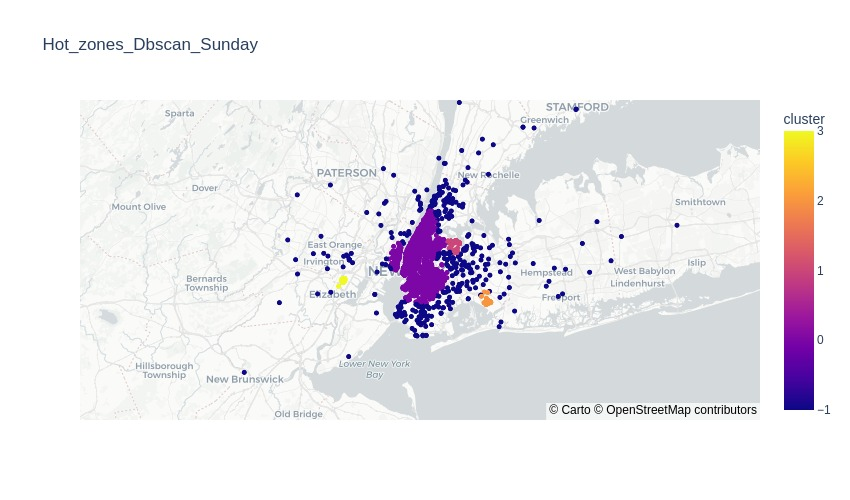

Cluster, number of pickups
 1    9592
-1     470
 2     341
 3     312
 0      83
Name: cluster, dtype: int64


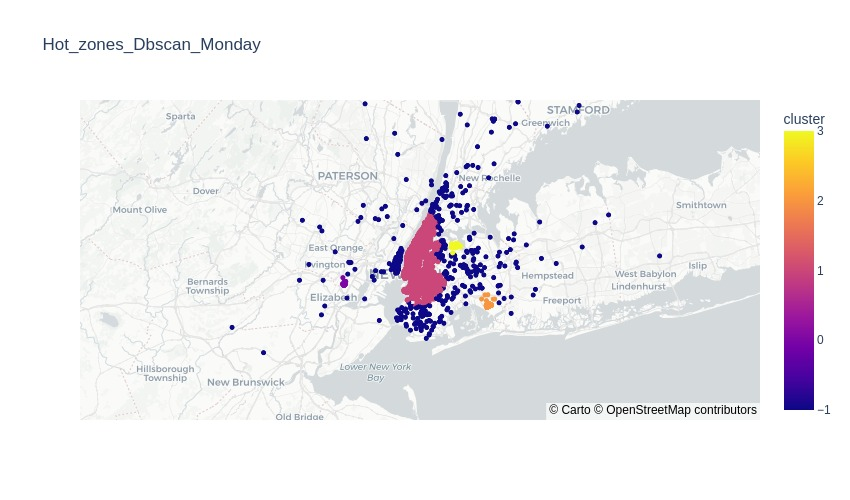

Cluster, number of pickups
 0    14820
-1      477
 1      293
 2      291
 3      106
 4      104
Name: cluster, dtype: int64


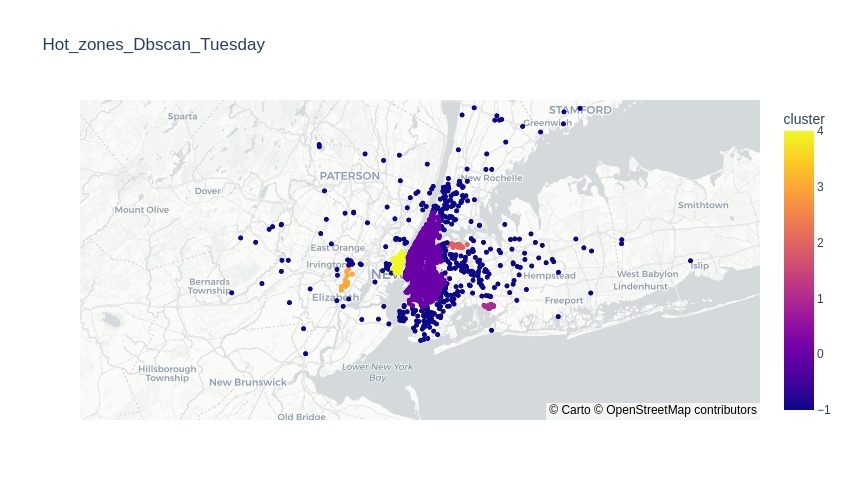

In [24]:
days = ['Sunday', 'Monday', 'Tuesday']
fit_predict(april, days)

Cluster, number of pickups
 0    18041
-1      460
 3      381
 1      328
 4      116
 2      104
Name: cluster, dtype: int64


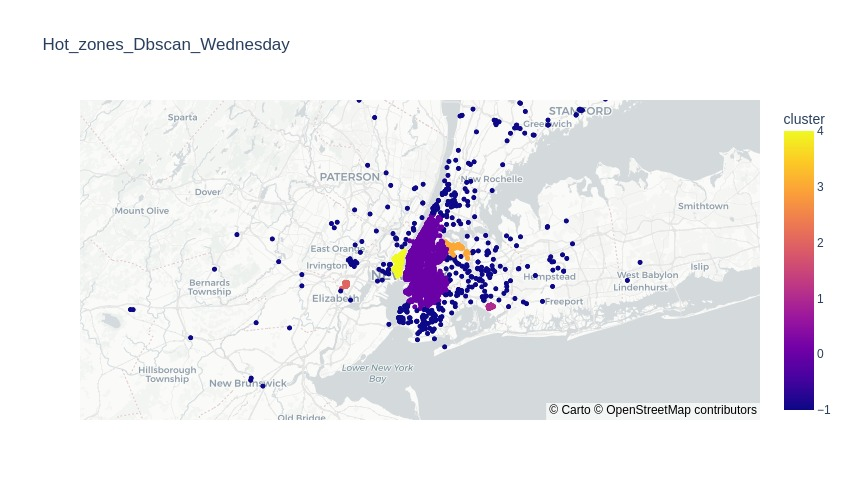

Cluster, number of pickups
 0    13930
-1      467
 1      439
 2      242
 3       99
 4       90
Name: cluster, dtype: int64


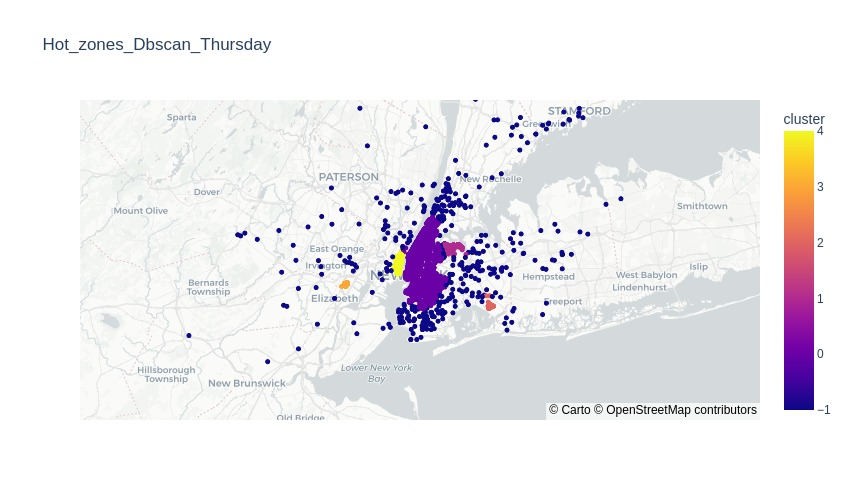

Cluster, number of pickups
 0    14787
-1      457
 3      266
 2      239
 1       84
Name: cluster, dtype: int64


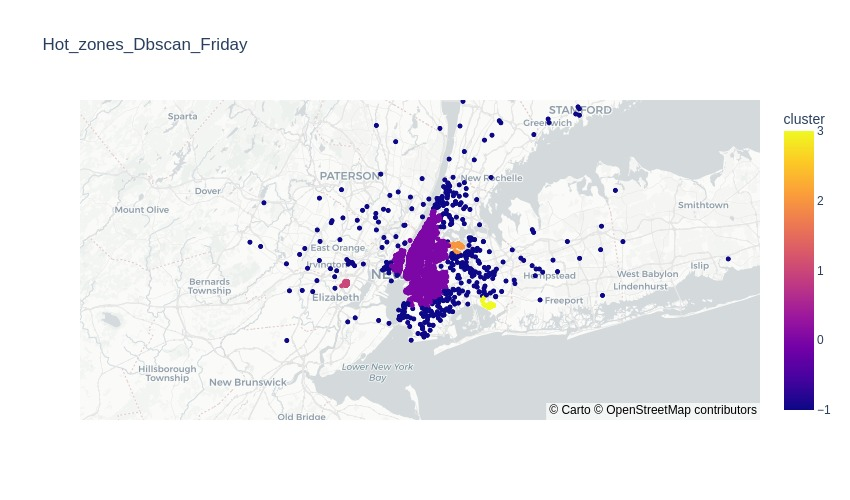

Cluster, number of pickups
 0    12830
-1      493
 2      187
 1      123
Name: cluster, dtype: int64


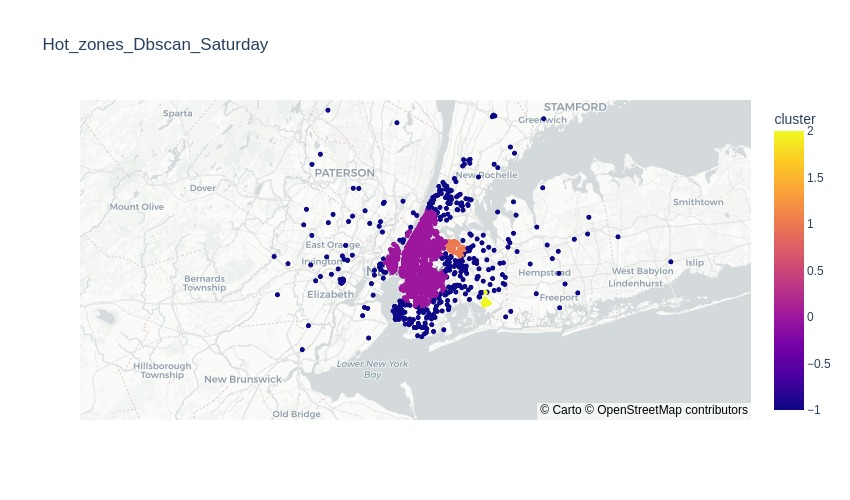

In [25]:
days = ['Wednesday', 'Thursday', 'Friday', 'Saturday']
fit_predict(april, days)


> Conclusion: Depending on the day, the clusters found by DBSCAN are different.  It is more suited to use DBSCAN than Kmeans because like that we can capture different pickup densities, thus different formes.

> Something to explore:  
- Different distances per Day of group of days
- Minimum samples to consider a cluster
- Check the clusters per hour